In [1]:
import streamlit as st
from PIL import Image
from skimage import data
from skimage import transform
from skimage.feature import blob_log
from matplotlib import pyplot as plt
from skyfield.api import Star, Topos, load
from skyfield.data import hipparcos
import numpy as np
from scipy.optimize import curve_fit
import os
import time
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

In [2]:
stardict = {}
with open('common_stars.txt') as f:
    lines = f.readlines()
    for line in lines:
        entry = line.strip().split("\t")
        stardict[int(entry[1])] = entry[0]
        stardict[int(entry[3])] = entry[2]

df = df[df['magnitude'] <= 3.0]
print('After filtering, there are {} stars'.format(len(df)))
bright_stars = Star.from_dataframe(df)

planets = load('de421.bsp')
earth = planets['earth']
ts = load.timescale()


After filtering, there are 177 stars


In [3]:
# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _gaussian(M, x0, y0, xalpha, yalpha, A):
    x, y = M
    arr = gaussian(x, y, x0, y0, xalpha, yalpha, A)
    return arr

0.002
2 15
3 5
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 5
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 5
2 15
1 3
2 15
2 15
2 15
2 14
3 5
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
2 15
0 7
2 15
2 15
2 15
2 15
2 15
1 6
2 14
2 15
2 15
2 15
2 15
2 15
2 15
2 7
2 15
3 5
2 15
2 16
2 15
2 15
3 6
2 15
1 2
2 15
2 15
1 15
2 15
2 15
2 15
2 15
2 2
2 15
2 15
0 3
2 16
2 15
3 5
2 18
2 15
2 15
2 5
2 15
2 13
2 15
2 15
3 8
3 5
2 8
2 15
2 9
2 15
2 15
2 15
2 12
2 9
2 14
2 15
2 16
2 15
2 15
2 15
2 15
2 17
2 15
2 15
2 18
2 15
3 2
2 15
2 3
2 15
2 15
2 16
4 18
2 15
2 15
2 15
2 9
2 16
2 15
2 15
2 17
3 16
2 15
2 15
2 16
2 15
4 19
2 16
2 15
2 15
4 19
4 12
2 8
2 15
2 15
4 17
4 5
3 2
4 10
2 13
0 9
2 15
2 15
2 15
2 9
2 15
2 14
2 15
2 15
2 15
2 5
2 15
1 9
2 15
2 14
2 4
3 0
0 6
2 15
4 18
2 3
2 15
2 15
2 9
2 16
3 5
4 18
2 3
2 15
2 15
1 9
2 15
2 15
4 11
4 

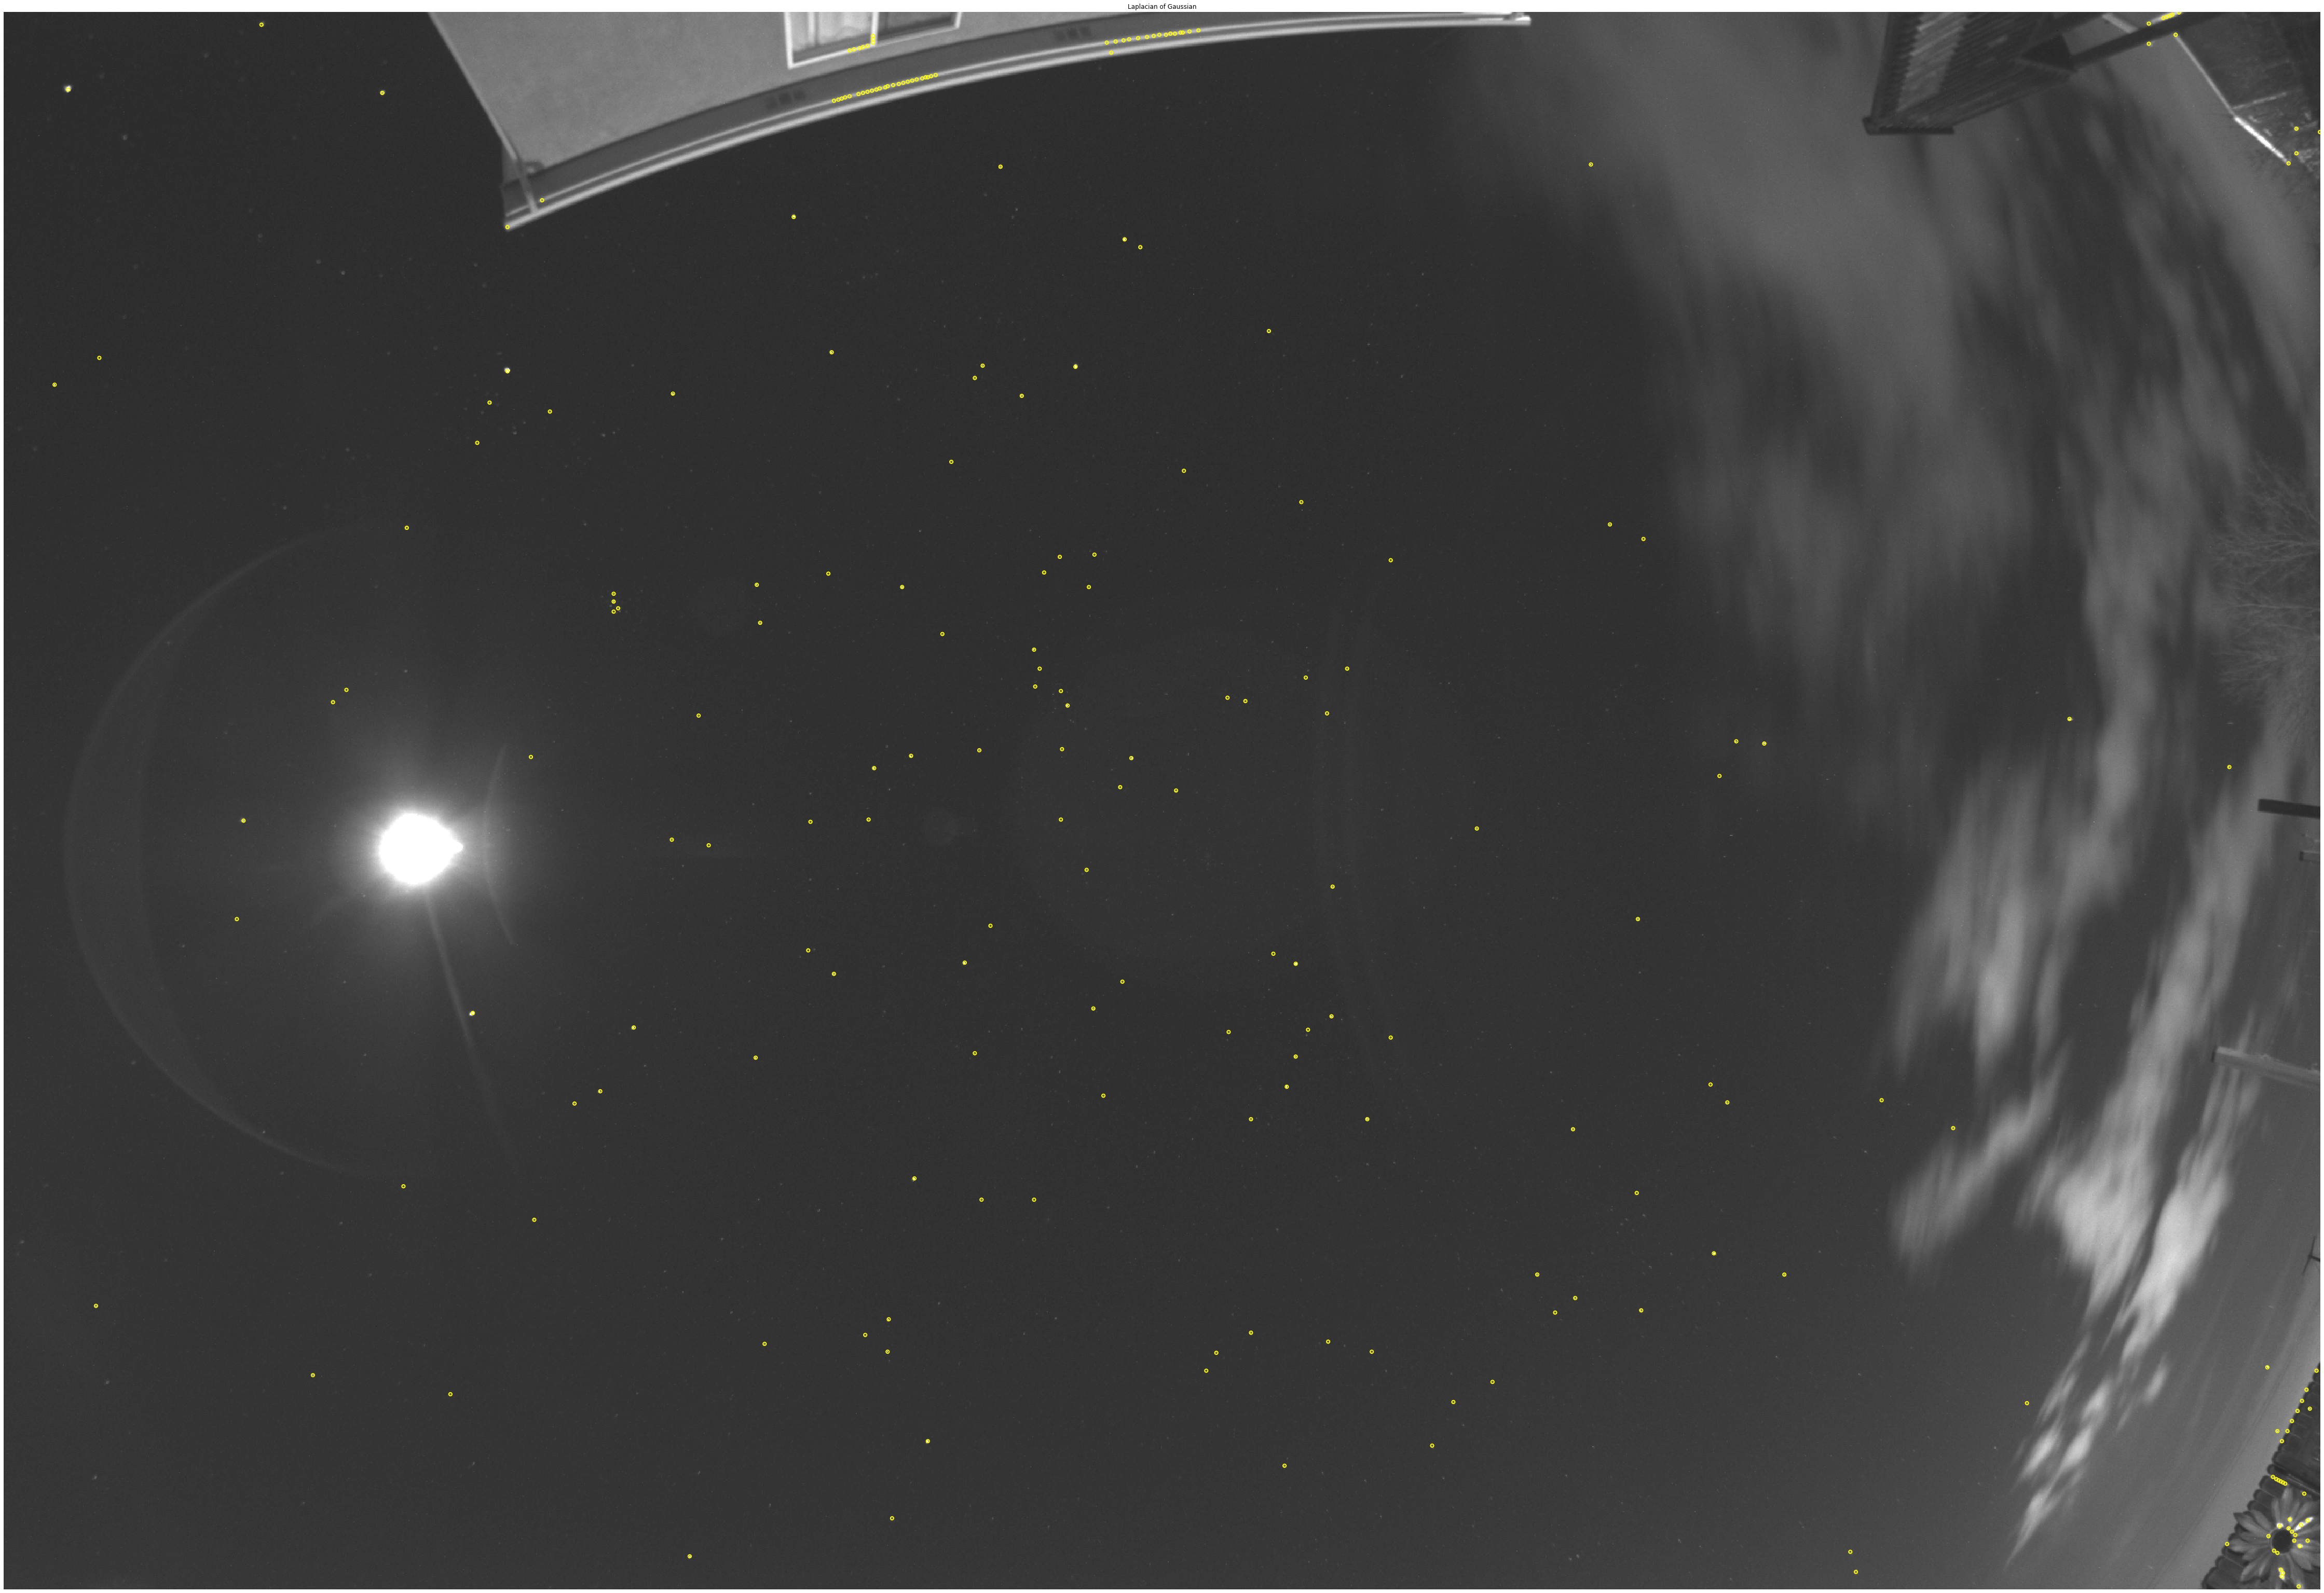

In [4]:
def getMag(parray, blobs):
    ret = np.zeros((len(blobs), 4))
    mx,my = parray.shape
    mx-=1
    my-=1
    for cnt,blob in enumerate(blobs):
        x,y,r = blob
#         y = my+1-y
        ret[cnt,:3] = blob
        startx = int(x-2)
        starty = int(y-2)
        endx = int(x+2)
        endy = int(y+2)
        if startx < 0:
            startx = 0
        if starty < 0:
            starty = 0
        if endx > mx:
            endx = mx
        if endy > my:
            endy = my        
#         print(parray.shape,parray[startx:endx,starty:endy].shape)
        test = parray[startx:endx,starty:endy].shape
        if test[0] > 0 and test[1] > 0:
            # The two-dimensional domain of the fit.
#             xmin, xmax, nx = startx, endx, test[0]
#             ymin, ymax, ny = starty, endy, test[1]
#             x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
#             X, Y = np.meshgrid(x, y)
#             xdata = np.vstack((X.ravel(), Y.ravel()))
#             ydata = parray[startx:endx,starty:endy]
#             ydata /= np.max(ydata)
#             off = np.argmax(ydata)
#             rr = off // 4
#             cc = off - rr*4
#             print(rr,cc)
#             for row in ydata:
#                 print(row)

#             popt, pcov = curve_fit(_gaussian, xdata, ydata.ravel())
#             print(popt)
            vv = np.std(parray[startx:endx,starty:endy])
            ret[cnt,3] = np.max(parray[startx:endx,starty:endy]) / vv
#             break
    return ret

def getMax(parray, blobs):
    mx,my = parray.shape
    mx-=1
    my-=1
    for cnt,blob in enumerate(blobs):
        x,y,r,mag = blob
        startx = int(x-5)
        starty = int(y-5)
        endx = int(x+5)
        endy = int(y+5)
        if startx < 0:
            startx = 0
        if starty < 0:
            starty = 0
        if endx > mx:
            endx = mx
        if endy > my:
            endy = my        
        test = parray[startx:endx,starty:endy].shape
        if test[0] > 0 and test[1] > 0:
            ydata = parray[startx:endx,starty:endy]
            ydata /= np.max(ydata)
            off = np.argmax(ydata)
            rr = off // 20
            cc = off - rr*20
            print(rr,cc)

fig, ax = plt.subplots(1, 1, figsize=(80, 80), sharex=True, sharey=True)
myblobs = []

thresh = 0.002

# for cc in range(180):
for cc in range(1):
    fname = f"streamlit/pic{cc*10:06d}.dat"
    
    raw = np.fromfile(fname, dtype=np.float64).reshape((2822,4144))
#     print(raw.shape)

    tstamp = os.path.getmtime(fname)
#     print(tstamp)

    timestamp = datetime.fromtimestamp(tstamp)
#     print(timestamp.year)

    parray = 0.2125*raw[::2,::2] + 0.7154 * (raw[1::2,::2] + raw[::2,1::2]) / 2.0 + 0.0721 * raw[1::2,1::2]
    out = parray / np.max(parray)
    
    
    blobs_log = blob_log(out, max_sigma=120, num_sigma=5, threshold=thresh)
    
#     while len(blobs_log) < 150:
#         thresh *= 0.8
#         blobs_log = blob_log(out, max_sigma=120, num_sigma=5, threshold=thresh)
        
#     while len(blobs_log) > 200:
#         thresh /= 0.8
#         blobs_log = blob_log(out, max_sigma=120, num_sigma=5, threshold=thresh)

    # Compute radii in the 3rd column.
    print(thresh)
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
    blobs_log = blobs_log[np.where(blobs_log[:,2] <= 2)]
    blobs_log = getMag(parray, blobs_log)
    getMax(parray, blobs_log)
    
    print(blobs_log[:,3])
    swgain = 20
    print(fname, len(blobs_log))
    myblobs.append(blobs_log)

    blobs_list = [blobs_log]
    colors = ['yellow']
    titles = ['Laplacian of Gaussian']
    sequence = zip(blobs_list, colors, titles)

    # ax = axes.ravel()
    # ax[1].imshow(immask, cmap='gray', interpolation='none')
    # ax[1].set_title("Mask using variance")

    for idx, (blobs, color, title) in enumerate(sequence):
        ax.set_title(title)
        if cc == 0:
            ax.imshow(out*swgain, cmap='gray', interpolation='none',vmin=0.1, vmax=0.6)
        for blob in blobs:
            y, x, r, mag = blob
            if mag > 0:
                c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
                ax.add_patch(c)
        ax.set_axis_off()


cos = earth + Topos('38.8605998 N', '104.6751112 W', elevation_m=2000)
plt.show()

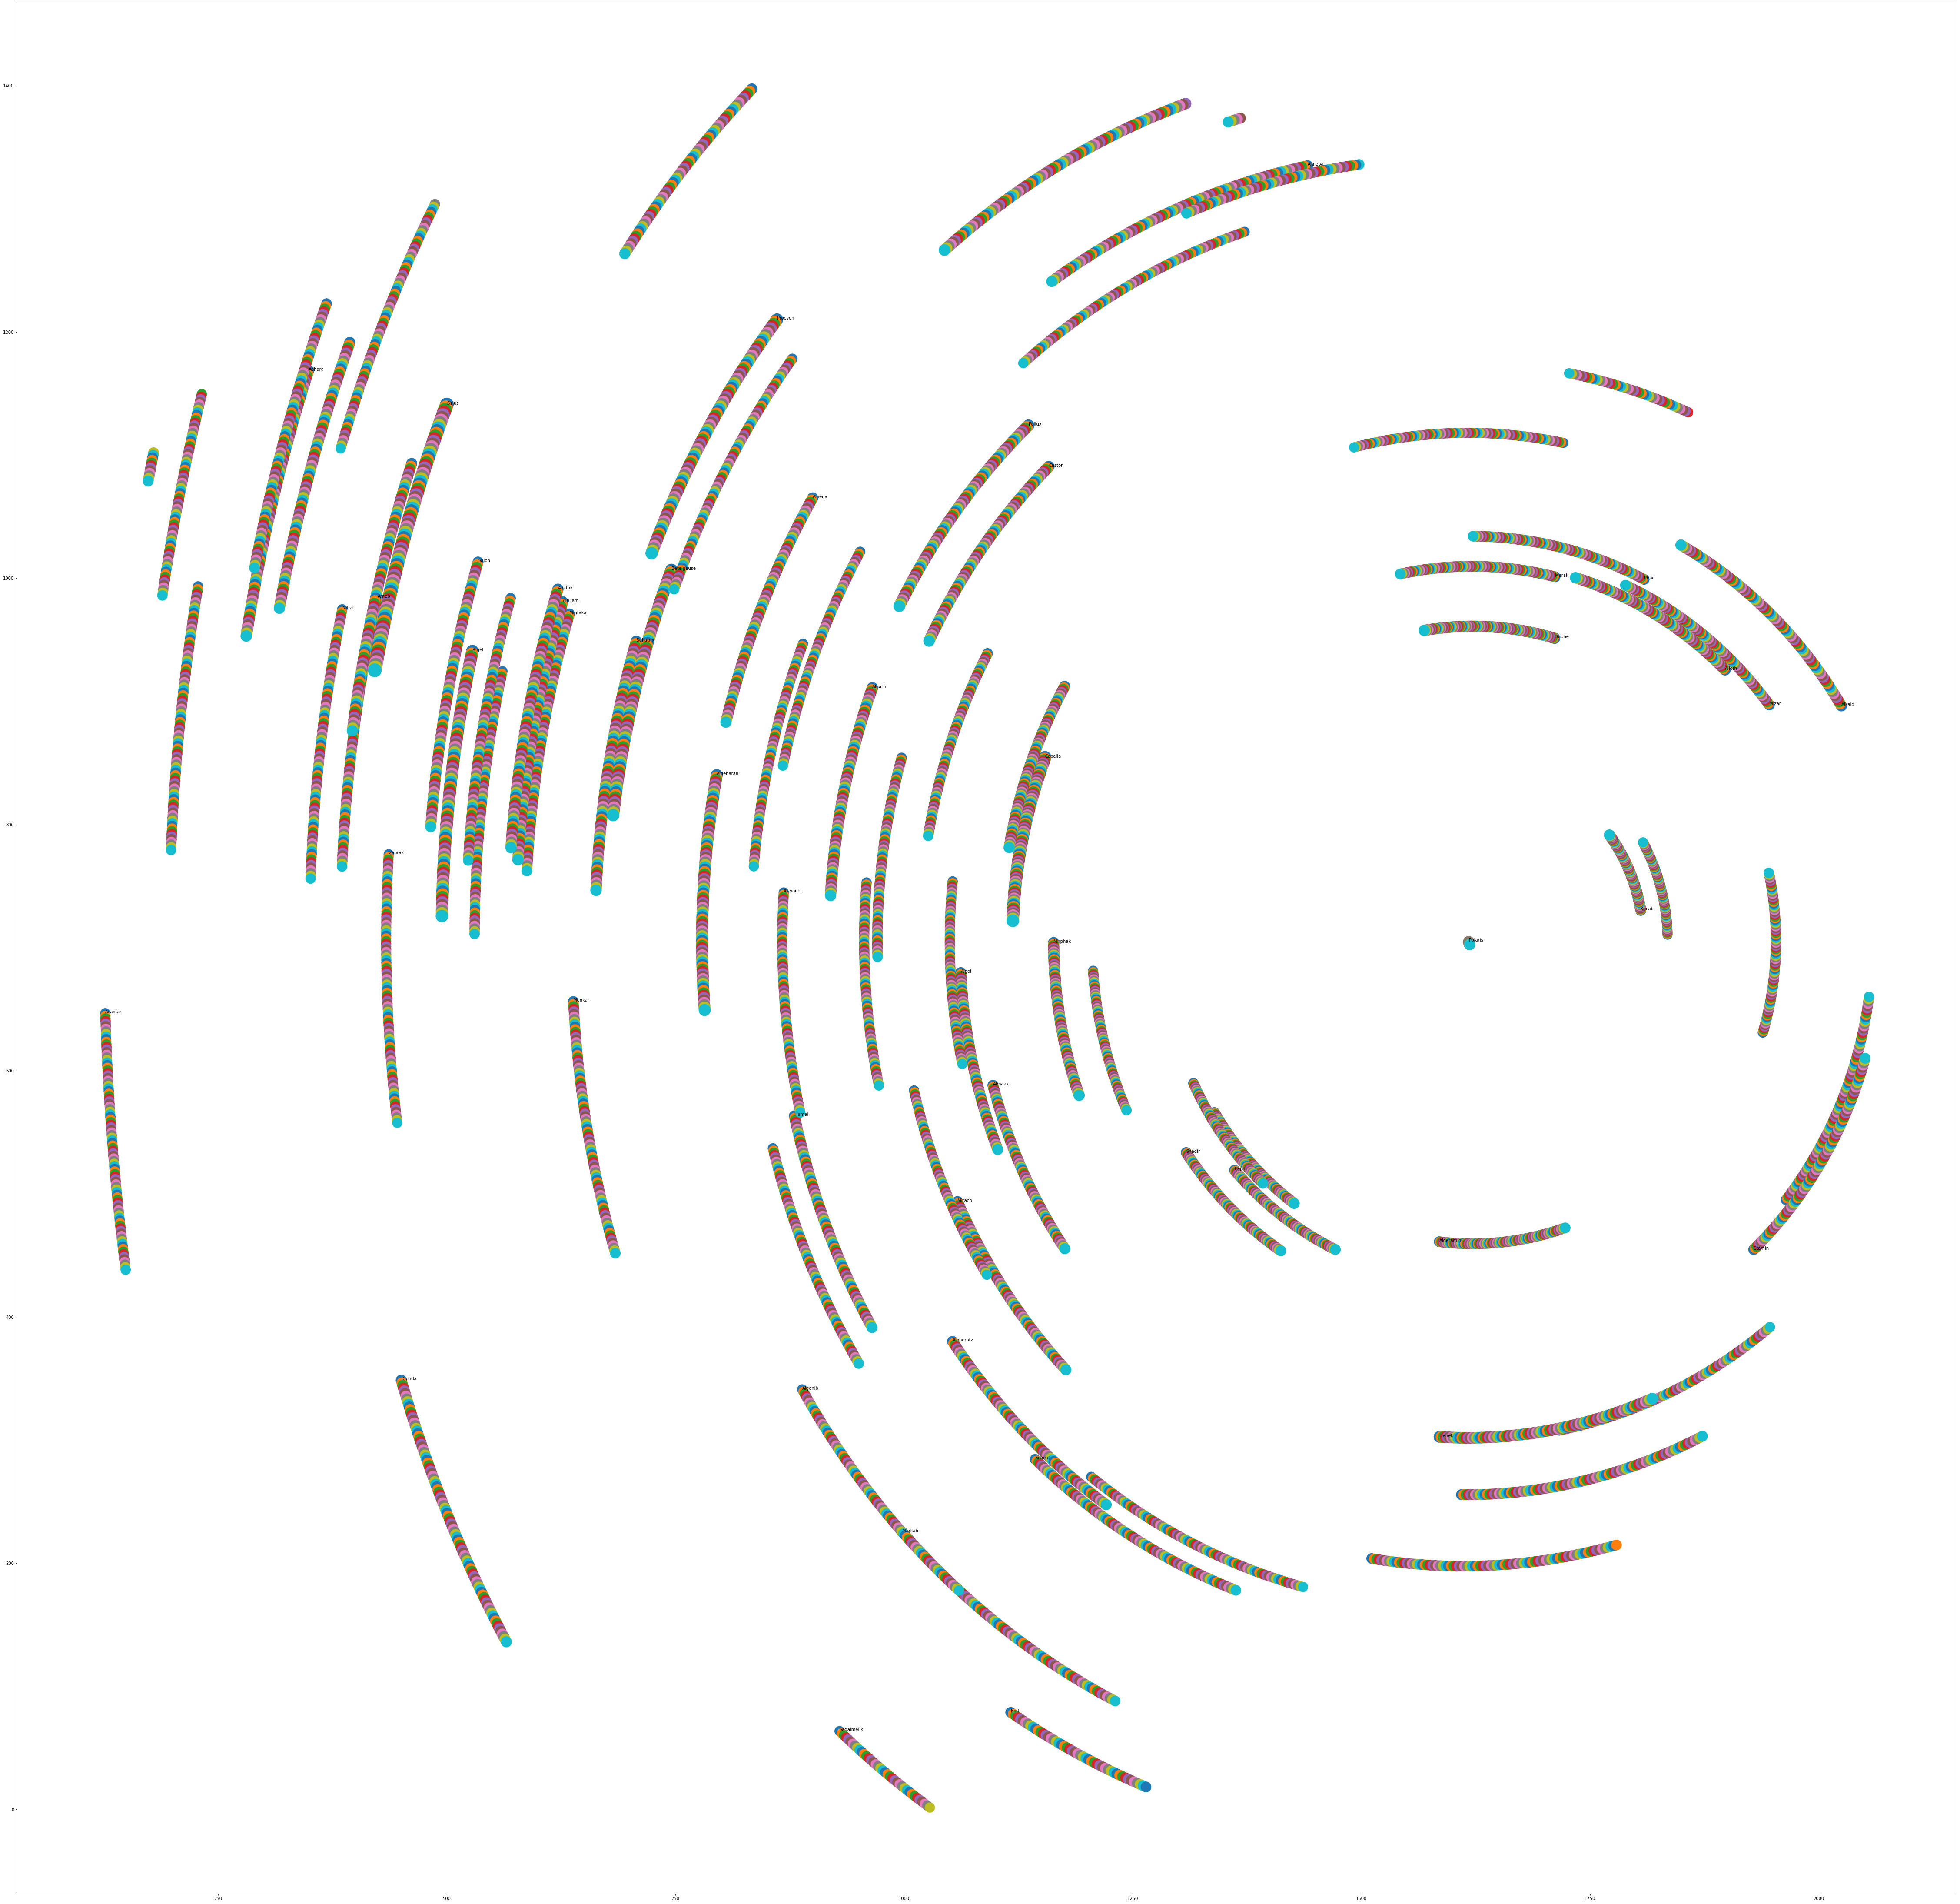

In [5]:
pickle.dump( myblobs, open( "blobs.p", "wb" ) )
fig, ax = plt.subplots(1, 1, figsize=(80, 80), sharex=True, sharey=True)

for cnt in range(100):
    t = ts.utc(timestamp.year, 
               timestamp.month, 
               timestamp.day, 
               timestamp.hour,
               timestamp.minute+cnt,
               timestamp.second)
#     print(t)
#     astrometric = boston.at(t).observe(bright_stars)
    apparent = cos.at(t).observe(bright_stars).apparent()
#     ra, dec, distance = apparent.radec('date')
    alt,az,distance = apparent.altaz()
    az_deg = np.pi*np.array(az.degrees) / 180
#     ax.scatter(az_deg, 90 - alt.degrees, 50*df['magnitude'], 'k')
    hips = df.index
    rad = 90 - alt.degrees
    idxs = np.where(rad < 90)
    mag = np.array(10*(8-df['magnitude']))
    x = (rad[idxs]*np.cos(az_deg[idxs])/180 + 0.5) * 4144/2
    y = (rad[idxs]*np.sin(az_deg[idxs])/180 + 0.5) * 2822/2
    hipvals = hips[idxs]
    ax.scatter(x, y,mag[idxs]*10)
#     print(np.min(x),np.max(x),np.min(y),np.max(y))
    
    if cnt == 0:
        for idx,hip in enumerate(hipvals):
            if hip in stardict:
                ax.annotate(stardict[hip], (x[idx], y[idx]))

plt.show()